# Analyze benchmark models

## 要約

 - Benchmark modelsの基礎的な分析として、各メタモデルとの相関を計算した。     
     - 現状最新のデータで解析を行うと、メタモデルは、新規Targetやjeromeの60d（`v43_lgbm_teager60` や `v4_lgbm_jerome60`）との相関が低く（スピアマン相関係数 = 0.63程度）、`v42_rain_ensemble` との相関が高かった（スピアマン相関係数 = 0.94程度）。
 - Benchmark modelsのMMCを計算してみた。よくわからん。

In [1]:
!pip install -Uqq numerapi

In [2]:
import os
import numerapi
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pylab as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from collections import defaultdict
from contextlib import redirect_stderr

In [3]:
napi = numerapi.NumerAPI()
# # Notebook実行時に大量に出力がでてしまうため抑制
# with redirect_stderr(open(os.devnull, 'w')):
#     napi.download_dataset("v4.3/validation_int8.parquet", "validation.parquet")
#     napi.download_dataset("v4.3/live_int8.parquet", "live.parquet")
#     napi.download_dataset("v4.3/meta_model.parquet", "meta_model.parquet")
#     napi.download_dataset("v4.3/live_benchmark_models.parquet", "live_benchmark_models.parquet")
#     napi.download_dataset("v4.3/validation_benchmark_models.parquet", "validation_benchmark_models.parquet")

In [4]:
df_val_bench = pd.read_parquet("/kaggle/input/numerai-v4-3-midnight/v4.3/validation_benchmark_models.parquet")
df_metamodel = pd.read_parquet("/kaggle/input/numerai-v4-3-midnight/v4.3/meta_model.parquet")

## ValidationのBenchmark modelsとメタモデルの相関

In [5]:
df_val_bench_mm = pd.concat([df_val_bench, df_metamodel.drop(["era", "data_type"], axis=1)], axis=1)
df_val_bench_mm.dropna(inplace=True)

In [6]:
# 各Eraごとに相関を計算
dd = defaultdict(lambda: defaultdict(int))
for era in tqdm(df_val_bench_mm["era"].unique()):
    df_ext = df_val_bench_mm.query("era == @era")
    for col in df_ext.columns:
        if col[0] != "v":
            continue
        dd[col][era] = st.spearmanr(df_ext[col], df_ext["numerai_meta_model"])[0]
df_corr = pd.DataFrame(dd)
df_corr.to_csv("benchmark_corr_with_metamodels.csv")
print("Era: ", df_corr.tail(10).index[0], "-", df_corr.tail(10).index[-1])

  0%|          | 0/230 [00:00<?, ?it/s]

Era:  1108 - 1117


In [7]:
# 直近10Eraの相関係数の平均値
df_corr.tail(10).mean().sort_values(ascending=False).to_frame()

,0
v42_rain_ensemble,0.923975
v43_lgbm_cyrus20,0.912039
v43_lgbm_ct_blend,0.896923
v42_example_preds,0.895290
v42_teager_ensemble,0.894247
v42_rain_ensemble2,0.881016
v42_lgbm_ct_blend,0.877984
v42_teager_plus_cyrus,0.877984
v43_lgbm_cyrus60,0.858401
v41_lgbm_cyrus20,0.817247


In [8]:
fig = go.Figure()
for col in df_corr.columns:
    fig.add_trace(go.Scatter(x=df_corr.index, y=df_corr[col], mode='lines', name=col))

# Update layout
fig.update_layout(title='Line Plot of Meta model correlation', xaxis_title='Era', yaxis_title='Corr')

# Show plot
fig.show()

## MMCの計算

https://github.com/numerai/numerai-tools/blob/master/numerai_tools/scoring.py を参考に、MMCを計算してみます。

In [9]:
def contribution(predictions: pd.DataFrame, meta_model: pd.Series, live_targets: pd.Series) -> pd.Series:
    """与えられた予測に関する与えられたメタモデルとの貢献相関を計算します。

    その後、次の手順で貢献相関を計算します：
    1. 各予測とメタモデルを順位付けし、順位を保持します
    2. 各予測とメタモデルをガウス化します
    3. 各予測をメタモデルに関して直交化します
    4. 直交化された予測とターゲットを乗算します

    引数:
        predictions: pd.DataFrame - 評価する予測
        meta_model: pd.Series - 評価対象のメタモデル
        live_targets: pd.Series - 評価対象のライブターゲット

    戻り値:
        pd.Series - 予測の各列の結果の貢献相関スコア
    """
    def rank(df: pd.DataFrame, method: str = "average") -> pd.DataFrame:
        return df.apply(lambda series: (series.rank(method=method).values - 0.5) / series.count())

    def tie_kept_rank(df: pd.DataFrame) -> pd.DataFrame:
        # rank columns, but keep ties
        return rank(df, "average")

    def filter_sort_index(s1, s2, max_filtered_ratio=0.2):
        ids = s1.dropna().index.intersection(s2.dropna().index)
        # ensure we didn't filter too many ids
        assert len(ids) / len(s1) >= (1 - max_filtered_ratio)
        assert len(ids) / len(s2) >= (1 - max_filtered_ratio)
        return s1.loc[ids].sort_index(), s2.loc[ids].sort_index()

    def gaussian(df: pd.DataFrame) -> pd.DataFrame:
        assert np.array_equal(df.index.sort_values(), df.index)
        return df.apply(lambda series: st.norm.ppf(series))

    def orthogonalize(v, u):
        return v - np.outer(u, (v.T @ u) / (u.T @ u))

    # 予測、メタモデル、ターゲットをお互いにフィルタリングして並び替える
    meta_model, predictions = filter_sort_index(meta_model, predictions)
    live_targets, predictions = filter_sort_index(live_targets, predictions)
    live_targets, meta_model = filter_sort_index(live_targets, meta_model)

    # メタモデルと予測を順位付けして正規化して平均=0、標準偏差=1にします
    p = gaussian(tie_kept_rank(predictions)).values
    m = gaussian(tie_kept_rank(meta_model.to_frame()))[meta_model.name].values

    # 予測をメタモデルに関して直交化します
    neutral_preds = orthogonalize(p, m)

    # ターゲットを中心化します
    live_targets -= live_targets.mean()

    # ターゲットと中立化された予測を乗算します
    # 平均=0なので、これは共分散に相当します
    mmc = (live_targets @ neutral_preds) / len(live_targets)

    return pd.Series(mmc, index=predictions.columns)

In [10]:
df_val = pd.read_parquet("/kaggle/input/numerai-v4-3-midnight/v4.3/validation_int8.parquet", columns=["era", "target"])
df_val = df_val.loc[df_val["era"].isin(df_corr.index), :]
df_val.drop("era", axis=1, inplace=True)

In [11]:
df_val_bench_mm = pd.concat([df_val_bench_mm, df_val], axis=1)
df_val_bench_mm.head()

,era,v43_lgbm_teager60,v43_lgbm_teager20,v43_lgbm_cyrus60,v43_lgbm_cyrus20,v42_example_preds,v42_lgbm_teager60,v42_lgbm_teager20,v42_lgbm_agnes20,v42_lgbm_claudia20,...,v2_example_preds,v41_example_preds,v42_rain_ensemble,v42_rain_ensemble2,v42_teager_plus_cyrus,v42_teager_ensemble,v42_lgbm_ct_blend,v43_lgbm_ct_blend,numerai_meta_model,target
id,,,,,,,,,,,,,,,,,,,,,
n001310944632ecc,0888,0.494928,0.799844,0.692938,0.655287,0.597932,0.594226,0.694108,0.040968,0.767850,...,0.218884,0.260242,0.423137,0.431721,0.665236,0.515997,0.665236,0.749902,0.077546,0.25
n001509d6cac2951,0888,0.250683,0.216348,0.185135,0.088373,0.154897,0.482833,0.127585,0.457667,0.147679,...,0.789895,0.800234,0.279555,0.217714,0.120757,0.213227,0.120757,0.124464,0.527019,0.25
n002decc2c98be03,0888,0.791260,0.881584,0.970347,0.889192,0.852126,0.738783,0.830277,0.410652,0.831252,...,0.990441,0.911822,0.881194,0.757901,0.858954,0.871050,0.858954,0.902848,0.837788,0.50
n0030f8e1d4c53e0,0888,0.736052,0.929965,0.806282,0.951034,0.962934,0.711861,0.933086,0.411042,0.947522,...,0.828521,0.955131,0.944986,0.943816,0.961568,0.917284,0.961568,0.953765,0.960300,0.75
n00347d10b4bc00b,0888,0.778775,0.854077,0.840226,0.919625,0.894850,0.838666,0.929380,0.600273,0.940694,...,0.909871,0.584081,0.875536,0.857199,0.928209,0.902263,0.928209,0.908701,0.391436,0.75


In [12]:
# 例として、era == 1000のときのv43_lgbm_teager20のMMCを計算してみます。
df_ext = df_val_bench_mm.query("era == '1000'")
contribution(df_ext[["v43_lgbm_teager20"]], df_ext["numerai_meta_model"], df_ext["target"])

v43_lgbm_teager20    0.005216
dtype: float64

In [13]:
d = {}
cols_benchmark_model = df_val_bench_mm.columns[df_val_bench_mm.columns.str.startswith("v")]
for era in tqdm(df_corr.index):
    df_ext = df_val_bench_mm.query("era == @era")
    d[era] = contribution(df_ext[cols_benchmark_model], df_ext["numerai_meta_model"], df_ext["target"])

  0%|          | 0/230 [00:00<?, ?it/s]

In [14]:
df_mmc = pd.DataFrame(d).T
df_mmc.to_csv("bench_mark_mmc.csv")

### Benchmark modelのMMCの可視化

In [15]:
fig = go.Figure()
for col in df_mmc.columns:
    if col in ['v4_lgbm_jerome60', 'v4_lgbm_nomi20', 'v3_example_preds', 'v2_example_preds']:
        fig.add_trace(go.Scatter(x=df_mmc.index, y=df_mmc[col], mode='lines', name=col))

# Update layout
fig.update_layout(title='Line Plot of MMC Over Era (Not v4.3 data)', xaxis_title='Era', yaxis_title='MMC')

# Show plot
fig.show()

In [16]:
fig = go.Figure()
for col in df_mmc.columns:
    fig.add_trace(go.Scatter(x=df_mmc.index, y=df_mmc[col], mode='lines', name=col))

# Update layout
fig.update_layout(title='Line Plot of MMC Over Era (All)', xaxis_title='Era', yaxis_title='MMC')

# Show plot
fig.show()

In [17]:
df_mmc

,v43_lgbm_teager60,v43_lgbm_teager20,v43_lgbm_cyrus60,v43_lgbm_cyrus20,v42_example_preds,v42_lgbm_teager60,v42_lgbm_teager20,v42_lgbm_agnes20,v42_lgbm_claudia20,v42_lgbm_rowan20,...,v4_lgbm_jerome20,v3_example_preds,v2_example_preds,v41_example_preds,v42_rain_ensemble,v42_rain_ensemble2,v42_teager_plus_cyrus,v42_teager_ensemble,v42_lgbm_ct_blend,v43_lgbm_ct_blend
0888,0.008211,0.006339,0.005260,0.005411,0.005669,0.007701,0.005880,0.003473,0.006475,0.006454,...,0.001922,-0.000083,0.001036,0.002257,0.004483,0.005743,0.006228,0.006340,0.006228,0.006257
0889,0.010925,0.007574,0.003460,0.003148,0.004016,0.011993,0.008412,0.004234,0.009232,0.009101,...,0.003242,-0.000580,-0.000090,0.001257,0.004576,0.004695,0.006632,0.007960,0.006632,0.005729
0890,0.009451,0.006926,0.005042,0.004349,0.006339,0.011117,0.009958,0.006421,0.009607,0.009151,...,0.000983,-0.000626,-0.002719,0.000158,0.004627,0.006837,0.008813,0.009257,0.008813,0.006125
0891,0.010512,0.008167,0.005751,0.005199,0.006298,0.010099,0.008191,0.003617,0.008145,0.008390,...,0.000758,0.001365,0.001206,0.003724,0.004771,0.005996,0.007830,0.008395,0.007830,0.007292
0892,0.005898,0.006048,-0.000369,0.001604,0.002084,0.005045,0.005500,0.002331,0.006115,0.005210,...,0.002626,-0.000470,-0.000737,0.001227,0.002037,0.002242,0.004130,0.004284,0.004130,0.004123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.001202,0.004124,0.000117,0.001863,0.001068,0.000930,0.003736,-0.000978,0.003136,0.004184,...,-0.001926,-0.000931,-0.001126,0.002452,0.000236,0.002056,0.002544,0.001460,0.002544,0.003187
1114,0.001812,0.003374,-0.002395,0.000820,-0.001321,-0.000641,0.001037,0.000631,0.000829,0.000956,...,-0.002146,-0.000857,-0.004277,-0.002798,-0.002285,-0.000221,-0.000191,-0.000931,-0.000191,0.002284
1115,-0.001809,-0.000094,-0.001875,0.000389,-0.000533,-0.003153,-0.001552,-0.000129,-0.001713,-0.002600,...,-0.003804,-0.000156,-0.003360,-0.002179,-0.001753,0.000251,-0.001043,-0.002073,-0.001043,0.000218
1116,-0.002485,0.001675,-0.002115,0.001695,0.001617,-0.003123,0.000188,0.002161,-0.000269,-0.000054,...,-0.001784,0.001569,-0.000518,0.003112,-0.000011,0.002088,0.001033,-0.000462,0.001033,0.001902


In [18]:
df_corr

,v43_lgbm_teager60,v43_lgbm_teager20,v43_lgbm_cyrus60,v43_lgbm_cyrus20,v42_example_preds,v42_lgbm_teager60,v42_lgbm_teager20,v42_lgbm_agnes20,v42_lgbm_claudia20,v42_lgbm_rowan20,...,v4_lgbm_jerome20,v3_example_preds,v2_example_preds,v41_example_preds,v42_rain_ensemble,v42_rain_ensemble2,v42_teager_plus_cyrus,v42_teager_ensemble,v42_lgbm_ct_blend,v43_lgbm_ct_blend
0888,0.193927,0.224080,0.466277,0.553339,0.550790,0.183487,0.210179,0.467128,0.223707,0.206023,...,0.626809,0.646116,0.795693,0.510321,0.546568,0.528196,0.409037,0.415151,0.409037,0.419229
0889,0.197110,0.221157,0.466504,0.549870,0.546862,0.183362,0.212176,0.466793,0.227611,0.206169,...,0.628261,0.651097,0.790394,0.516225,0.542056,0.522081,0.408878,0.414093,0.408878,0.417385
0890,0.202988,0.227276,0.476878,0.552394,0.548207,0.188625,0.221992,0.482365,0.235907,0.218723,...,0.634420,0.652773,0.801749,0.528054,0.548546,0.529100,0.414115,0.421468,0.414115,0.420716
0891,0.194887,0.228686,0.481249,0.556933,0.555543,0.186961,0.227470,0.496695,0.235486,0.222923,...,0.646725,0.661767,0.806244,0.545058,0.555475,0.531185,0.423002,0.427671,0.423002,0.425167
0892,0.201877,0.243183,0.480142,0.554602,0.556788,0.194990,0.240756,0.509131,0.250722,0.233570,...,0.641506,0.658093,0.818770,0.544512,0.561968,0.537918,0.432181,0.438950,0.432181,0.432547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.704160,0.723802,0.865275,0.906288,0.885632,0.679908,0.706414,0.619248,0.700829,0.697495,...,0.722784,0.753570,0.670803,0.741318,0.920986,0.867926,0.860066,0.883347,0.860066,0.883717
1114,0.715932,0.754926,0.848990,0.907937,0.892494,0.695474,0.740015,0.629691,0.732397,0.731063,...,0.709744,0.745559,0.664816,0.739328,0.923491,0.880026,0.881585,0.899902,0.881585,0.900871
1115,0.708657,0.744522,0.857556,0.912396,0.894778,0.686102,0.729033,0.637861,0.726273,0.719280,...,0.707653,0.744522,0.666721,0.741843,0.925866,0.883894,0.875811,0.893436,0.875811,0.896502
1116,0.704246,0.738510,0.844609,0.895049,0.872976,0.674677,0.714466,0.627049,0.708441,0.704801,...,0.705239,0.742683,0.657050,0.723851,0.910241,0.866958,0.857211,0.879929,0.857211,0.884452


## MMCについての解析
### MetaModelとの相関は低い方がよさそう

In [19]:
corr_mm_target = {}
corr_benchmark_target = defaultdict(lambda: defaultdict(float))
for era in tqdm(df_corr.index):
    df_ext = df_val_bench_mm.query("era == @era")
    corr_mm_target[era] = st.spearmanr(df_ext["numerai_meta_model"], df_ext["target"])[0]
    
    for col in df_ext.columns:
        if col[0] == "v":
            corr_benchmark_target[era][col] = st.spearmanr(df_ext[col], df_ext["target"])[0]

  0%|          | 0/230 [00:00<?, ?it/s]

In [20]:
df_corr_benchmark_target = pd.DataFrame(corr_benchmark_target).T

In [21]:
era_list = []
mmc_benchmark = []
corr_benchmark_vs_target = []
corr_mm_vs_benchmark = []
corr_mm_vs_target = []
corr_mm_vs_target_posneg = []

cols = df_corr.columns
for era in df_corr.index:
    len_list = len(list(df_corr.loc[era, cols]))
    
    era_list.extend([era] * len_list)
    mmc_benchmark.extend(list(df_mmc.loc[era, cols]))
    corr_benchmark_vs_target.extend(list(df_corr_benchmark_target.loc[era, cols]))
    corr_mm_vs_benchmark.extend(list(df_corr.loc[era, cols]))
    corr_mm_vs_target.extend([corr_mm_target[era]] * len_list)
    
    if corr_mm_target[era] > 0:
        corr_mm_vs_target_posneg.extend([1] * len_list)
    else:
        corr_mm_vs_target_posneg.extend([0] * len_list)

In [22]:
df_benchmark_corr_mmc = pd.DataFrame({
    "Era": era_list,
    "MMC": mmc_benchmark,
    "Corr_BenchMark_Target": corr_benchmark_vs_target,
    "Corr_MetaModel_BenchMark": corr_mm_vs_benchmark,
    "Corr_Metamodel_Target": corr_mm_vs_target,
    "Corr_Metamodel_Target_PN":corr_mm_vs_target_posneg
})
df_benchmark_corr_mmc["Era"] = df_benchmark_corr_mmc["Era"].astype(int)

SignificanceResult(statistic=-0.39501551361467707, pvalue=0.0)


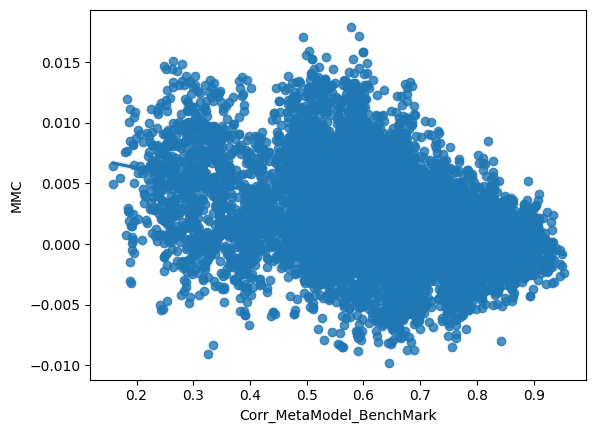

In [23]:
df_ext = df_benchmark_corr_mmc
x = "Corr_MetaModel_BenchMark"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

SignificanceResult(statistic=-0.07963212182361165, pvalue=0.1164023790065831)


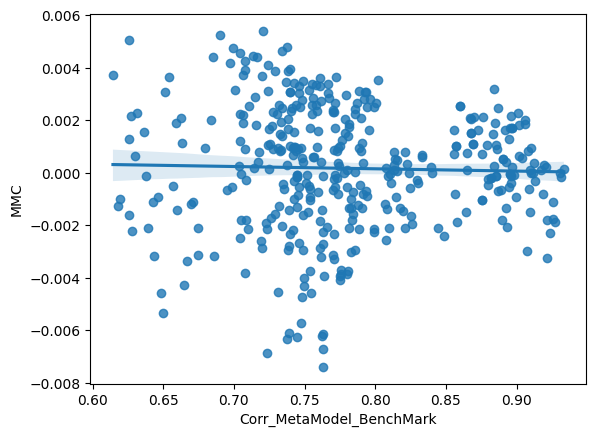

In [24]:
df_ext = df_benchmark_corr_mmc.query("Era > 1107")
x = "Corr_MetaModel_BenchMark"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

SignificanceResult(statistic=0.7038774704816212, pvalue=0.0)


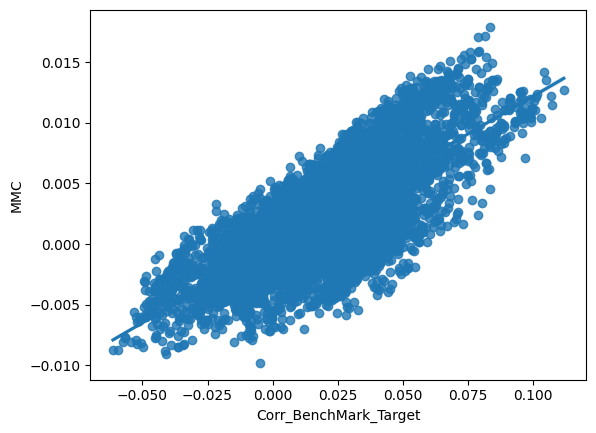

In [25]:
df_ext = df_benchmark_corr_mmc
x = "Corr_BenchMark_Target"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

SignificanceResult(statistic=0.3740649058298662, pvalue=1.9016051566015577e-23)


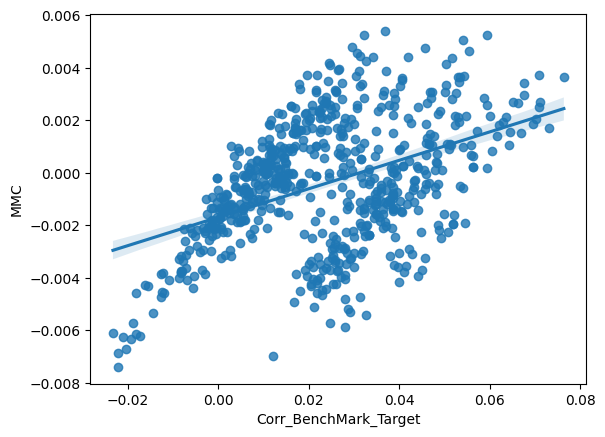

In [26]:
df_ext = df_benchmark_corr_mmc.query("Era > 1100")
x = "Corr_BenchMark_Target"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

In [27]:
df_benchmark_corr_mmc["Corr_BenchMark-Metamodel"] = df_benchmark_corr_mmc["Corr_BenchMark_Target"] - df_benchmark_corr_mmc["Corr_Metamodel_Target"]

SignificanceResult(statistic=0.8120618909874611, pvalue=0.0)


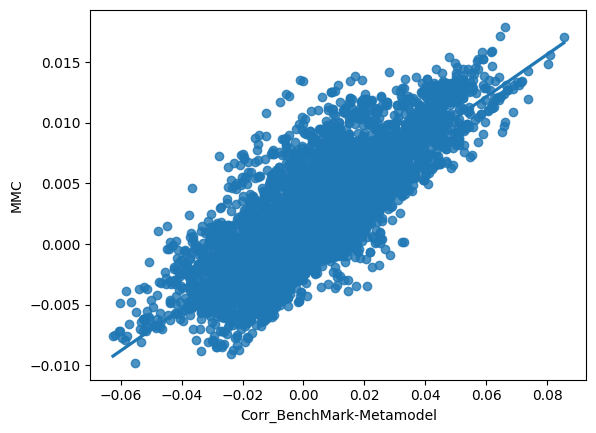

In [28]:
df_ext = df_benchmark_corr_mmc
x = "Corr_BenchMark-Metamodel"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

### 補足: メタモデルとの調子がよい方がよいか？悪い方がよいか？

SignificanceResult(statistic=-0.40506588248567293, pvalue=1.778032979389465e-275)


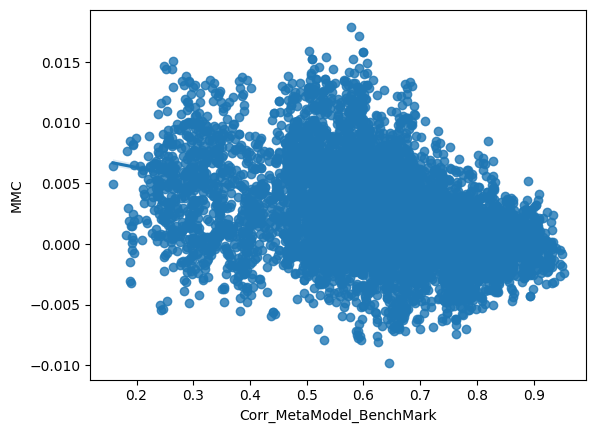

In [29]:
df_ext = df_benchmark_corr_mmc.query("Corr_Metamodel_Target_PN == 1")
x = "Corr_MetaModel_BenchMark"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))

SignificanceResult(statistic=-0.36659578898370165, pvalue=4.3868965308389227e-63)


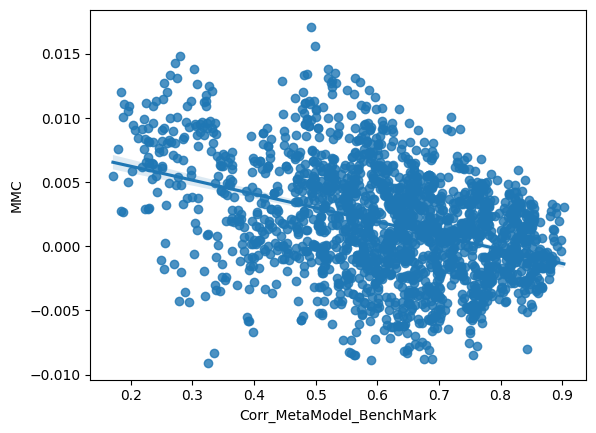

In [30]:
df_ext = df_benchmark_corr_mmc.query("Corr_Metamodel_Target_PN == 0")
x = "Corr_MetaModel_BenchMark"
y = "MMC"
sns.regplot(
    x=x,
    y=y,
    data=df_ext
)
print(st.spearmanr(df_ext[x], df_ext[y]))